In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import glob
import operator
import os
from os import listdir
import csv

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Build model

In [4]:
batch_size = 64
epochs = 100

In [5]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [7]:
def build_model():
    return Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
        ])

In [10]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15)

In [11]:
data_augmentation = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
                             layers.experimental.preprocessing.RandomRotation(0.1),
                             layers.experimental.preprocessing.RandomZoom(0.1)
                             ])

# Evaluation functions

In [12]:
# Model Evaluation

def model_predict(label, model, class_names):

    df = pd.DataFrame(columns=['name', 'actual', 'predicted', 'label'])

    path = '/content/drive/MyDrive/DISSERTATION/FINAL_seperate/' + label

    # images of class
    for filename in listdir(path):
        image_path = path + '/' + filename

        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array/255
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        output = predictions[0][0]

        if output > 0.5:
            key = label
        else:
            key = 'other'

        score = tf.nn.softmax(predictions[0])
        confidence = 100*np.max(score)

        df = df.append({'name': filename, 'actual' : label, 'predicted' : key, 'label' : label}, ignore_index=True)


    # images of counter-examples
    excel_path = '/content/drive/MyDrive/DISSERTATION/FINAL_seperate/final_' + label + '.xlsx'
    df_final = pd.read_excel(excel_path, index_col=None)

    path_other = '/content/drive/MyDrive/DISSERTATION/FINAL_all'

    for i in range(0, len(df_final)):
        filename = df_final.loc[i, 'name']
        image_path = path_other + '/' + filename

        image_path = path_other + '/' + filename
        other_label = filename.split("-")[0]
        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array/255
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        output = predictions[0][0]

        if output > 0.5:
            key = label
        else:
            key = 'other'

        score = tf.nn.softmax(predictions[0])
        confidence = 100*np.max(score)

        df = df.append({'name': filename, 'actual' : 'other', 'predicted' : key, 'label': other_label}, ignore_index=True)

    return df

In [13]:
def calc_model_acc(df):
    actual = df['actual'].tolist()
    predict = df['predicted'].tolist()
    accuracy = accuracy_score(predict, actual)*100
    accuracy = round(accuracy, 2)

    return accuracy

In [14]:
def calc_model_precision(df, class_names):
    actual = df['actual'].tolist()
    predict = df['predicted'].tolist()
    pos = class_names[0]
    precision = precision_score(actual, predict, average= 'binary', pos_label=pos)
    precision = round(precision, 2)

    return precision

In [15]:
def calc_model_recall(df, class_names):
    actual = df['actual'].tolist()
    predict = df['predicted'].tolist()
    pos = class_names[0]
    recall = recall_score(predict, actual, average= 'binary', pos_label=pos)
    recall = round(recall, 2)

    return recall

In [16]:
def calc_model_f1(df, class_names):
    actual = df['actual'].tolist()
    predict = df['predicted'].tolist()
    pos = class_names[0]
    f1_score = f1_score(predict, actual, average= 'weighted', pos_label=pos)
    f1_score = round(f1_score, 2)

    return f1_score

In [18]:
from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(df, class_names):
    actual = df['actual'].tolist()
    predict = df['predicted'].tolist()

    labels = ['True Neg','False Pos','False Neg','True Pos']
    names = [class_names[0], 'other']
    cf_matrix = confusion_matrix(actual, predict)

    df_cm = pd.DataFrame(cf_matrix, index=names, columns = names)
    plt.figure(figsize = (6,5))
    sn.set(font_scale=1.5)
    plot = sn.heatmap(df_cm, cmap='Greys', annot=True)
    plot.set_yticklabels(labels=plot.get_yticklabels(), va='center')

    return plot

In [19]:
def confused_by_class(df, class_name):
    '''
    Counter-examples from which classes get more frequently mis-classified as the class the model is meant to recognise?
    '''
    summary = []
    names = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']

    for i in range(len(names)):
        name = names[i]

        if name == class_name:
            summary.append(0)
        else:
            a = len(df.loc[(df.label == name) & (df.predicted == class_name)])
            summary.append(a)

    d = {'class_name': names, 'images_confused': summary}

    return pd.DataFrame(d)

# Re-load and evaluate the models

## 1 - Advanced stop

In [20]:
class_names_1 = ['advanced_stop', 'other_a']

In [21]:
model_1 = build_model()

In [22]:
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=adam,
    metrics=['accuracy'])

In [23]:
model_1 = load_model('/content/drive/MyDrive/DISSERTATION/1/model_1_weights_final.hdf5')

In [24]:
df_1 = model_predict('advanced_stop', model_1, class_names_1)

In [25]:
acc = calc_model_acc(df_1)
precision = calc_model_precision(df_1, class_names_1)
recall = calc_model_recall(df_1, class_names_1)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 85.0
Precision: 0.88
Recall: 0.88
F1-score: 0.88


In [26]:
df_1.head(10)

,name,actual,predicted,label
0,advanced_stop-000284_1.jpg,advanced_stop,advanced_stop,advanced_stop
1,advanced_stop-000284_2.jpg,advanced_stop,other,advanced_stop
2,advanced_stop-000243_2.jpg,advanced_stop,other,advanced_stop
3,advanced_stop-000241_2.jpg,advanced_stop,other,advanced_stop
4,advanced_stop-000243_1.jpg,advanced_stop,advanced_stop,advanced_stop
5,advanced_stop-000241_1.jpg,advanced_stop,advanced_stop,advanced_stop
6,advanced_stop-000244_2.jpg,advanced_stop,advanced_stop,advanced_stop
7,advanced_stop-000244_1.jpg,advanced_stop,advanced_stop,advanced_stop
8,advanced_stop-000269_2.jpg,advanced_stop,advanced_stop,advanced_stop
9,advanced_stop-000271_1.jpg,advanced_stop,advanced_stop,advanced_stop


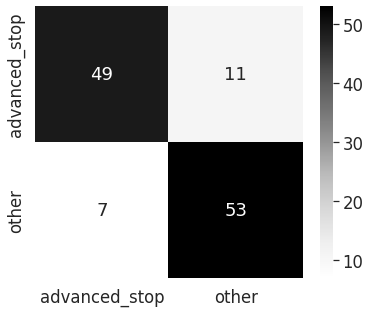

In [27]:
confusion_matrix_1 = plot_confusion_matrix(df_1, class_names_1)

In [28]:
confused_by_class_1 = confused_by_class(df_1, 'advanced_stop')
confused_by_class_1

,class_name,images_confused
0,advanced_stop,0
1,crossing,3
2,lane,0
3,parking,1
4,restricted_route,0
5,signal,0
6,traffic_calming,3


## 2 - Crossing

In [29]:
class_names_2 = ['crossing', 'other_c']

In [30]:
model_2 = build_model()

In [31]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=adam,
              metrics=['accuracy'])

In [32]:
model_2 = load_model('/content/drive/MyDrive/DISSERTATION/2/model_2_weights_final.hdf5')

In [33]:
df_2 = model_predict('crossing', model_2, class_names_2)

In [34]:
accuracy = calc_model_acc(df_2)
precision = calc_model_precision(df_2, class_names_2)
recall = calc_model_recall(df_2, class_names_2)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 76.67
Precision: 0.79
Recall: 0.79
F1-score: 0.79


In [35]:
df_2.head(10)

,name,actual,predicted,label
0,crossing-000024_2.jpg,crossing,crossing,crossing
1,crossing-000024_1.jpg,crossing,crossing,crossing
2,crossing-003327_1.jpg,crossing,other,crossing
3,crossing-003332_2.jpg,crossing,crossing,crossing
4,crossing-003332_1.jpg,crossing,other,crossing
5,crossing-003327_2.jpg,crossing,other,crossing
6,crossing-000019_1.jpg,crossing,other,crossing
7,crossing-000019_2.jpg,crossing,crossing,crossing
8,crossing-030319_1.jpg,crossing,crossing,crossing
9,crossing-003317_2.jpg,crossing,other,crossing


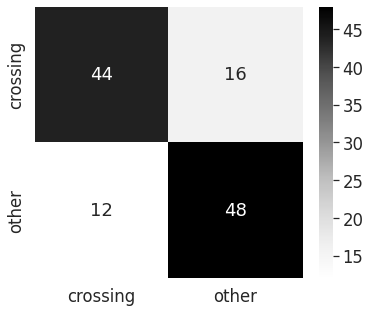

In [36]:
confusion_matrix_2 = plot_confusion_matrix(df_2, class_names_2)

In [37]:
confused_by_class_2 = confused_by_class(df_2, 'crossing')
confused_by_class_2

,class_name,images_confused
0,advanced_stop,2
1,crossing,0
2,lane,0
3,parking,1
4,restricted_route,2
5,signal,2
6,traffic_calming,4


## 3 - Lane

In [38]:
class_names_3 = ['lane', 'other_l']

In [39]:
model_3 = build_model()

In [40]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=adam,
                metrics=['accuracy'])

In [41]:
model_3.load_weights('/content/drive/MyDrive/DISSERTATION/3/model_3_weights_final.hdf5')

In [42]:
df_3 = model_predict('lane', model_3, class_names_3)

In [43]:
df_3.head(10)

,name,actual,predicted,label
0,cycle_lane-000044_2.jpg,lane,lane,lane
1,cycle_lane-000030_1.jpg,lane,lane,lane
2,cycle_lane-000030_2.jpg,lane,lane,lane
3,cycle_lane-000044_1.jpg,lane,lane,lane
4,cycle_lane-000069_1.jpg,lane,other,lane
5,cycle_lane-000069_2.jpg,lane,other,lane
6,cycle_lane-000045_1.jpg,lane,other,lane
7,cycle_lane-000045_2.jpg,lane,lane,lane
8,cycle_lane-000070_2.jpg,lane,lane,lane
9,cycle_lane-000071_1.jpg,lane,lane,lane


In [44]:
acc = calc_model_acc(df_3)
precision = calc_model_precision(df_3, class_names_3)
recall = calc_model_recall(df_3, class_names_3)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 73.33
Precision: 0.75
Recall: 0.75
F1-score: 0.75


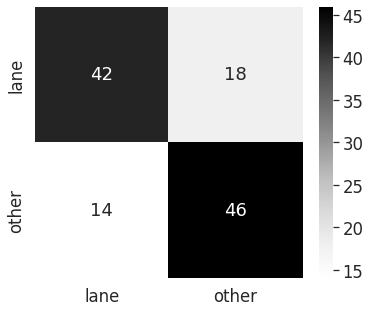

In [45]:
confusion_matrix_3 = plot_confusion_matrix(df_3, class_names_3)

In [46]:
confused_by_class_3 = confused_by_class(df_3, 'lane')
confused_by_class_3

,class_name,images_confused
0,advanced_stop,3
1,crossing,4
2,lane,0
3,parking,0
4,restricted_route,3
5,signal,2
6,traffic_calming,2


## 4 - Parking

In [47]:
class_names_4 = ['parking', 'other_p']

In [48]:
model_4 = build_model()

In [49]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=adam,
                metrics=['accuracy'])

In [50]:
model_4.load_weights('/content/drive/MyDrive/DISSERTATION/4/model_4_weights.hdf5')

In [51]:
df_4 = model_predict('parking', model_4, class_names_4)

In [52]:
df_4.head(10)

,name,actual,predicted,label
0,parking-000405_1.jpg,parking,parking,parking
1,parking-000405_2.jpg,parking,parking,parking
2,parking-000406_1.jpg,parking,parking,parking
3,parking-000406_2.jpg,parking,parking,parking
4,parking-000401_1.jpg,parking,parking,parking
5,parking-000402_1.jpg,parking,parking,parking
6,parking-000402_2.jpg,parking,parking,parking
7,parking-000403_1.jpg,parking,parking,parking
8,parking-000386_1.jpg,parking,parking,parking
9,parking-000385_1.jpg,parking,parking,parking


In [53]:
acc = calc_model_acc(df_4)
precision = calc_model_precision(df_4, class_names_4)
recall = calc_model_recall(df_4, class_names_4)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 87.5
Precision: 0.83
Recall: 0.83
F1-score: 0.83


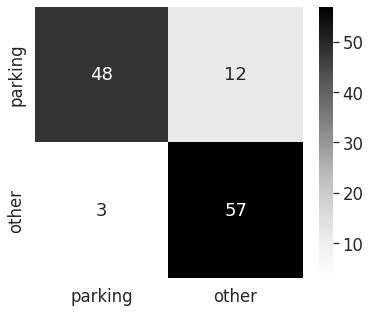

In [54]:
confusion_matrix_4 = plot_confusion_matrix(df_4, class_names_4)

In [55]:
confused_by_class_4 = confused_by_class(df_4, 'parking')
confused_by_class_4

,class_name,images_confused
0,advanced_stop,1
1,crossing,3
2,lane,0
3,parking,0
4,restricted_route,3
5,signal,0
6,traffic_calming,2


## 5 - Restricted route

In [56]:
class_names_5 = ['restricted_route', 'other_r']

In [57]:
model_5 = build_model()

In [58]:
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=adam,
                metrics=['accuracy'])

In [59]:
model_5.load_weights('/content/drive/MyDrive/DISSERTATION/5/model_5_weights_final.hdf5')

In [60]:
df_5 = model_predict('restricted_route', model_5, class_names_5)

In [61]:
df_5.head(10)

,name,actual,predicted,label
0,restricted_route-066919_1.jpg,restricted_route,restricted_route,restricted_route
1,restricted_route-066919_2.jpg,restricted_route,other,restricted_route
2,restricted_route-032691_2.jpg,restricted_route,restricted_route,restricted_route
3,restricted_route-032691_1.jpg,restricted_route,restricted_route,restricted_route
4,restricted_route-066918_1.jpg,restricted_route,other,restricted_route
5,restricted_route-042396_2.jpg,restricted_route,restricted_route,restricted_route
6,restricted_route-066918_2.jpg,restricted_route,other,restricted_route
7,restricted_route-066933_1.jpg,restricted_route,restricted_route,restricted_route
8,restricted_route-042912_1.jpg,restricted_route,restricted_route,restricted_route
9,restricted_route-066917_1.jpg,restricted_route,other,restricted_route


In [62]:
acc = calc_model_acc(df_5)
precision = calc_model_precision(df_5, class_names_5)
recall = calc_model_recall(df_5, class_names_5)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 79.17
Precision: 0.89
Recall: 0.89
F1-score: 0.89


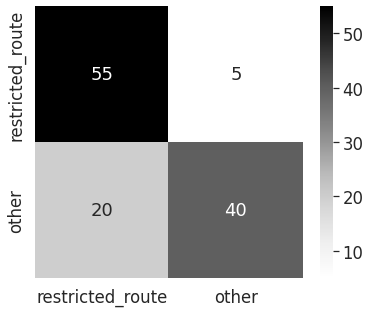

In [63]:
confusion_matrix_5 = plot_confusion_matrix(df_5, class_names_5)

In [64]:
confused_by_class_5 = confused_by_class(df_5, 'restricted_route')
confused_by_class_5

,class_name,images_confused
0,advanced_stop,0
1,crossing,0
2,lane,0
3,parking,1
4,restricted_route,0
5,signal,2
6,traffic_calming,1


## 6 - Signal

In [65]:
class_names_6 = ['signal', 'other_s']

In [66]:
model_6 = build_model()

In [67]:
model_6.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=adam,
                metrics=['accuracy'])

In [68]:
model_6.load_weights('/content/drive/MyDrive/DISSERTATION/6/model_6_weights_final.hdf5')

In [69]:
df_6 = model_predict('signal', model_6, class_names_6)

In [70]:
df_6.head(10)

,name,actual,predicted,label
0,signal-001915_2.jpg,signal,signal,signal
1,signal-001914_2.jpg,signal,signal,signal
2,signal-001914_1.jpg,signal,signal,signal
3,signal-001915_1.jpg,signal,signal,signal
4,signal-001919_2.jpg,signal,signal,signal
5,signal-001919_1.jpg,signal,signal,signal
6,signal-016915_2.jpg,signal,signal,signal
7,signal-016924_1.jpg,signal,signal,signal
8,signal-016915_1.jpg,signal,signal,signal
9,signal-016919_2.jpg,signal,signal,signal


In [71]:
acc = calc_model_acc(df_6)
precision = calc_model_precision(df_6, class_names_6)
recall = calc_model_recall(df_6, class_names_6)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 90.0
Precision: 0.9
Recall: 0.9
F1-score: 0.9


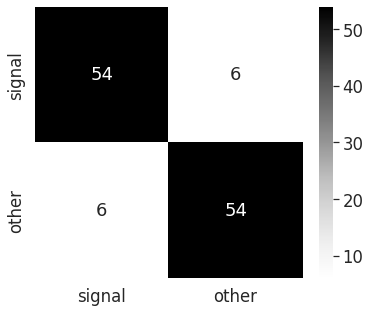

In [72]:
confusion_matrix_6 = plot_confusion_matrix(df_6, class_names_6)

In [73]:
confused_by_class_6 = confused_by_class(df_6, 'signal')
confused_by_class_6

,class_name,images_confused
0,advanced_stop,0
1,crossing,0
2,lane,0
3,parking,1
4,restricted_route,3
5,signal,0
6,traffic_calming,0


## 7 - Traffic calming

In [74]:
class_names_7 = ['traffic_calming', 'other_t']

In [75]:
model_7 = build_model()

In [76]:
model_7.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=adam,
                metrics=['accuracy'])

In [77]:
model_7.load_weights('/content/drive/MyDrive/DISSERTATION/7/model_7_weights_final.hdf5')

In [78]:
df_7 = model_predict('traffic_calming', model_7, class_names_7)

In [79]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_7)

df_7.head(10)

,name,actual,predicted,label
0,traffic_calming-9.jpg,traffic_calming,other,traffic_calming
1,traffic_calming-5.jpg,traffic_calming,traffic_calming,traffic_calming
2,traffic_calming-8.jpg,traffic_calming,traffic_calming,traffic_calming
3,traffic_calming-6.jpg,traffic_calming,traffic_calming,traffic_calming
4,traffic_calming-12.jpg,traffic_calming,other,traffic_calming
5,traffic_calming-0.jpg,traffic_calming,traffic_calming,traffic_calming
6,traffic_calming-10.jpg,traffic_calming,traffic_calming,traffic_calming
7,traffic_calming-3.jpg,traffic_calming,traffic_calming,traffic_calming
8,traffic_calming-2.jpg,traffic_calming,traffic_calming,traffic_calming
9,traffic_calming-13.jpg,traffic_calming,traffic_calming,traffic_calming


In [80]:
acc = calc_model_acc(df_7)
precision = calc_model_precision(df_7, class_names_7)
recall = calc_model_recall(df_7, class_names_7)

F1 = 2 * (precision * recall) / (precision + recall)
F1 = round(F1, 2)

print('Accuracy: ' + str(acc))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-score: ' + str(F1))

Accuracy: 70.0
Precision: 0.66
Recall: 0.66
F1-score: 0.66


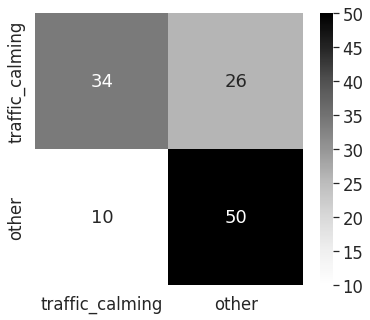

In [81]:
confusion_matrix_7 = plot_confusion_matrix(df_7, class_names_7)

In [82]:
confused_by_class_7 = confused_by_class(df_7, 'traffic_calming')
confused_by_class_7

,class_name,images_confused
0,advanced_stop,9
1,crossing,4
2,lane,0
3,parking,3
4,restricted_route,3
5,signal,0
6,traffic_calming,0


# Evaluation

### Individual binary classifier models

Summarise the accuracies of individual binary classifier models, and calculate average accuracy across the 5 seperate models

In [85]:
names = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']
models_list = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
class_names_list = [class_names_1, class_names_2, class_names_3, class_names_4, class_names_5, class_names_6, class_names_7]

In [86]:
accuracy_df = pd.DataFrame(columns=['class_predicted', 'accuracy'])

for i in range(0, 7):
    name = names[i]
    model = models_list[i]
    class_name = class_names_list[i]
    df = model_predict(name, model, class_name)
    acc = calc_model_acc(df)

    accuracy_df = accuracy_df.append({'class_predicted' : name, 'accuracy' : acc}, ignore_index=True)

In [87]:
accuracy_df

,class_predicted,accuracy
0,advanced_stop,85.00
1,crossing,76.67
2,lane,73.33
3,parking,87.50
4,restricted_route,79.17
5,signal,90.00
6,traffic_calming,70.00


In [88]:
avg_accuracy = sum(accuracy_df['accuracy'].tolist())/7
avg_accuracy

80.23857142857143

### Ensemble evaluation on unseen images

Evaluate the ensemble of binary classifiers model accuracy on unseen images set aside from the original dataset for model evaluation; allows for multiple labels to be predicted for 1 image.

In [89]:
models_list = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
class_names_list = [class_names_1, class_names_2, class_names_3, class_names_4, class_names_5, class_names_6, class_names_7]
labels = ['advanced_stop', 'crossing', 'lane','parking', 'restricted_route', 'signal', 'traffic_calming']

In [93]:
df_ensemble_on_images = pd.DataFrame(columns=['photo_name', 'actual_labels', 'predicted_labels', 'correct'])

for i in range(len(labels)):
    l = labels[i]
    path = '/content/drive/MyDrive/DISSERTATION/FINAL_seperate/' + l
    actual_list = []
    actual_list.append(l)

    for filename in listdir(path):
        image_path = path + '/' + filename

        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array = img_array/255

        prediction_list = []
        other = 'other'

        for i in range(0, len(models_list)):
            model = models_list[i]
            label = labels[i]

            predictions = model.predict(img_array)
            output = predictions[0][0]


            if output > 0.5:
                prediction_list.append(label)
            else:
                continue

        intersection_set = set.intersection(set(prediction_list), set(actual_list))
        intersection_list = list(intersection_set)

        df_ensemble_on_images = df_ensemble_on_images.append({'photo_name': filename, 'actual_labels' : l, 'predicted_labels' : prediction_list, 
                                                              'correct' : len(intersection_list)}, ignore_index=True)

Find that the ensemble model finds the correct label correctly (True Positives) in 80% of the cases (out of 420 images total); however, the rate of False Positives where other labels are falsely identified in addition to true positives is still very high

In [97]:
identified_main_class = sum(df_ensemble_on_images['correct'].to_list())/len(df_ensemble_on_images)
identified_main_class

0.8

### Ensemble evaluation on unseen video images

Evaluate the ensemble of binary classifiers model accuracy on unseen images generated from videos of cycling infrastructure in London (generated specifically for this project by author); allows for multiple labels to be predicted for 1 image.

In [99]:
video_images = pd.read_excel('/content/drive/MyDrive/DISSERTATION/video_images.xlsx', index_col=None)

In [100]:
df_ensemble_on_video = pd.DataFrame(columns=['name', 'actual_labels',  'predicted_labels', 'total_actual', 'correct'])

for i in range(0, len(video_images)):
    filename = video_images.loc[i, 'name']

    actual_list = [video_images.loc[i, 'class_1'], video_images.loc[i, 'class_2'], video_images.loc[i, 'class_3'], video_images.loc[i, 'class_4']]
    actual_list = [x for x in actual_list if pd.isnull(x) == False]

    path = '/content/drive/MyDrive/DISSERTATION/VIDEOS'
    image_path = path + '/' + filename

    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array/255
    
    prediction_list = []
    other = 'other'

    for i in range(0, len(models_list)):
        model = models_list[i]
        label = labels[i]

        predictions = model.predict(img_array)
        output = predictions[0][0]


        if output > 0.5:
            prediction_list.append(label)
        else:
            continue

    intersection_set = set.intersection(set(prediction_list), set(actual_list))
    intersection_list = list(intersection_set)

    df_ensemble_on_video = df_ensemble_on_video.append({'name': filename, 'actual_labels' : actual_list, 'predicted_labels' : prediction_list, 'total_actual' : len(actual_list), 'correct' : len(intersection_list)}, ignore_index=True)

In [105]:
index_list = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']

In [106]:
actual = []
actual_list = df_ensemble_on_video['actual_labels'].tolist()

for n in range(len(actual_list)):
    out = []
    item = actual_list[n]

    for i in range(0,7):
        if index_list[i] in item:
            out.append(1)
        else:
            out.append(0)
  
    actual.append(out)

In [107]:
predicted = []
predicted_list = df_ensemble_on_video['predicted_labels'].tolist()

for n in range(len(predicted_list)):
    out = []
    item = predicted_list[n]

    for i in range(0,7):
        if index_list[i] in item:
            out.append(1)
        else:
            out.append(0)

    predicted.append(out)

In [108]:
correct = df_ensemble_on_video['correct'].tolist()
total_actual = df_ensemble_on_video['total_actual'].tolist()
labels_identified_from_video = sum(correct)/sum(total_actual)*100
labels_identified_from_video

38.800000000000004

In [111]:
label_names = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']
print(classification_report(actual, predicted,target_names=label_names))

                  precision    recall  f1-score   support

   advanced_stop       0.19      0.95      0.31        20
        crossing       0.38      0.39      0.38        62
            lane       0.78      0.34      0.47        94
         parking       0.26      0.30      0.28        30
restricted_route       0.50      0.13      0.21        15
          signal       0.00      0.00      0.00        11
 traffic_calming       0.12      0.61      0.20        18

       micro avg       0.28      0.39      0.33       250
       macro avg       0.32      0.39      0.26       250
    weighted avg       0.47      0.39      0.36       250
     samples avg       0.29      0.38      0.30       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion matrices

In [1]:
label_names = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']

In [134]:
confused_by_class_1

,class_name,images_confused
0,advanced_stop,0
1,crossing,3
2,lane,0
3,parking,1
4,restricted_route,0
5,signal,0
6,traffic_calming,3


In [128]:
g = globals()
array = []

for i in range(0,7):
    varname = 'confused_by_class_{}'.format(i+1)
    df = g[varname]
    total_correct = 60 - sum(df['images_confused'])
    df.loc[i,'images_confused'] = total_correct
    array.append(df['images_confused'].to_list())

In [131]:
array

[[53, 3, 0, 1, 0, 0, 3],
 [2, 49, 0, 1, 2, 2, 4],
 [3, 4, 46, 0, 3, 2, 2],
 [2, 3, 0, 50, 2, 0, 3],
 [0, 0, 0, 1, 56, 2, 1],
 [0, 0, 0, 1, 3, 56, 0],
 [9, 4, 0, 3, 3, 0, 41]]

[Text(0, 0.5, 'advanced_stop'),
 Text(0, 1.5, 'crossing'),
 Text(0, 2.5, 'lane'),
 Text(0, 3.5, 'parking'),
 Text(0, 4.5, 'restricted_route'),
 Text(0, 5.5, 'signal'),
 Text(0, 6.5, 'traffic_calming')]

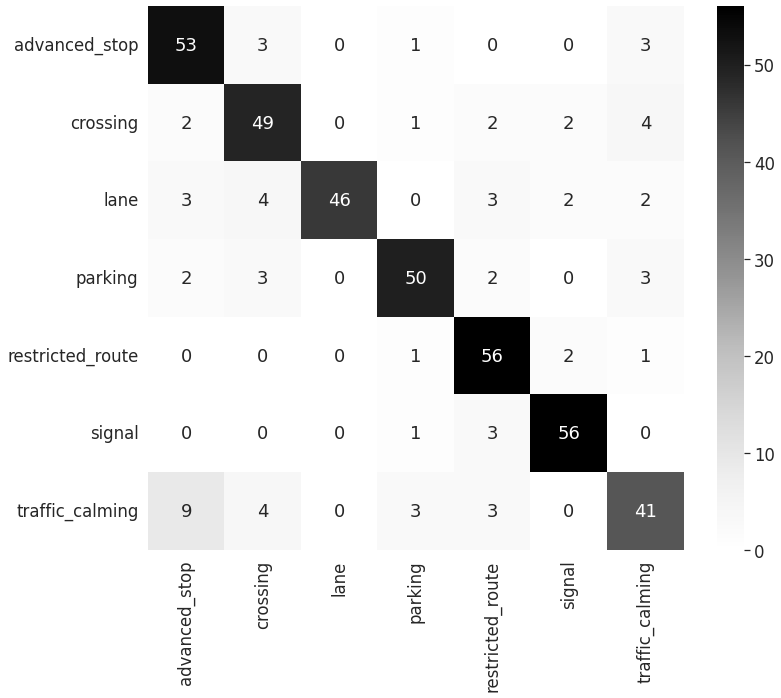

In [135]:
seperate_matrix = np.array(array)

index_list = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']
columns_list = ['advanced_stop', 'crossing', 'lane', 'parking', 'restricted_route', 'signal', 'traffic_calming']

df_cm = pd.DataFrame(seperate_matrix, index=index_list, columns = columns_list)
sn.set(font_scale=1.5)
plt.figure(figsize = (12,10))
full_confusion = sn.heatmap(df_cm,cmap='Greys', annot=True)
full_confusion.set_yticklabels(labels=full_confusion.get_yticklabels(), va='center')

## Extracting and visualising a kernel

In [136]:
# Load the weights into the model
model.load_weights('/content/drive/MyDrive/DISSERTATION/6/model_6_weights_final.hdf5')

# Get the first convolutional layer from the model
c1 = model.layers[0]

# Get the weights of the first convolutional layer
weights1 = c1.get_weights()

# Pull out the first channel of the first kernel in the first layer
kernel = weights1[0][...,0, 0]
print(kernel)

[[ 0.04383927 -0.07372971 -0.03207574]
 [-0.01302918  0.18979524 -0.17604314]
 [ 0.13445085  0.06784385 -0.05790473]]
